Define Model M1 : Vanilla LSTM

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Take the output of the last timestep
        return out


In [ ]:
torch.set_default_device("cuda")

Load Datasets

In [4]:
json_file_path = "train_file.json"

with open(json_file_path, "r") as f:
    train_data = json.load(f)


json_file_path = "val_file.json"

with open(json_file_path, "r") as f:
    val_data = json.load(f)

In [5]:
comp_utterances_train, comp_utterances_val = [], []
comp_labels_train, comp_labels_val = [], []

for i in range(len(train_data)):
    comp_utterances_train += train_data[i]["utterances"]
    comp_labels_train += train_data[i]["emotions"]

for i in range(len(val_data)):
    comp_utterances_val += val_data[i]["utterances"]
    comp_labels_val += val_data[i]["emotions"]

In [ ]:
comp_utterances_train

In [2]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# from transformers import BertTokenizer, BertModel
# import torch

# # Load pre-trained BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# # Tokenize and embed the sentences using BERT
# tokenized_sentences = tokenizer(comp_utterances_train, padding=True, truncation=True, return_tensors='pt')
# with torch.no_grad():
#     outputs = bert_model(**tokenized_sentences)
#     bert_embeddings = outputs.last_hidden_state
sbert_embeddings = model.encode(comp_utterances_train)
# Prepare labels
label_map = {"anger": 0, "fear": 1, "disgust": 2, "sadness": 3, "joy": 4, "surprise": 5, "neutral": 6}
labels_encoded = [label_map[label] for label in comp_labels_train]



In [7]:
sbert_embeddings_tensor = torch.tensor(sbert_embeddings,device='cuda')
labels_tensor = torch.tensor(labels_encoded,device='cuda')

# Create a PyTorch dataset
dataset = TensorDataset(sbert_embeddings_tensor, labels_tensor)

# Define batch size
batch_size = 1

# Create a PyTorch data loader
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
val_embeddings=model.encode(comp_utterances_val)
val_labels_encoded = [label_map[label] for label in comp_labels_val]
val_embeddings_tensor = torch.tensor(val_embeddings,device='cuda')
val_labels_tensor = torch.tensor(val_labels_encoded,device='cuda')

# Create a PyTorch dataset
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

In [ ]:
dataset[0]

In [ ]:
len(dataset)

58957

In [ ]:
sbert_embeddings_tensor.shape

torch.Size([58957, 384])

In [ ]:
#torch.cuda.manual_seed_all(0)
# Print first batch of data
# for batch in train_loader:
#     batch_embeddings, batch_labels = batch
#     print("Batch embeddings shape:", batch_embeddings.shape)
#     print("Batch labels:", batch_labels)
#     break


Batch embeddings shape: torch.Size([1, 384])
Batch labels: tensor([4])


In [9]:
torch.cuda.is_available()

True

In [11]:
device=torch.device('cuda')

In [ ]:
sbert_embeddings_tensor[0].shape

torch.Size([384])

In [12]:
# Hyperparameters
input_size = 384  # Size of word embeddings
hidden_size = 128  # Number of units in the LSTM hidden state
num_layers = 3  # Number of LSTM layers
output_size = len(list(label_map.keys()))  # Number of output classes
learning_rate = 0.001
num_epochs = 10

# Initialize GRU model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Training loop
train_losses=[]
val_losses=[]
for epoch in range(num_epochs):
    train_loss=0.0
    #Training loop
    model.train()
    for i in range(len(dataset)):
        inputs=sbert_embeddings_tensor[i].unsqueeze(0)
        labels=labels_tensor[i].unsqueeze(0)
        #print(inputs.shape)
        # Forward pass
        #print(labels)
        outputs = model(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_loss/=len(dataset)
    train_losses.append(train_loss)
    #Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(len(val_dataset)):
            inputs = val_embeddings_tensor[i].unsqueeze(0)
            labels = val_labels_tensor[i].unsqueeze(0)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss/=len(val_dataset)
    val_losses.append(val_loss)
    # Print loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}],Training Loss: {train_loss} \t Validation Loss: {val_loss}')

Epoch [1/10],Training Loss: 0.24368644475470175 	 Validation Loss: 0.2965102705476866
Epoch [2/10],Training Loss: 0.16909346647097623 	 Validation Loss: 0.1938684214535143
Epoch [3/10],Training Loss: 0.1372683865355496 	 Validation Loss: 0.17707420782866298
Epoch [4/10],Training Loss: 0.11650946457884734 	 Validation Loss: 0.15635997757797107
Epoch [5/10],Training Loss: 0.10600400545540264 	 Validation Loss: 0.16428482051700583
Epoch [6/10],Training Loss: 0.09686916324889756 	 Validation Loss: 0.14192967171865833
Epoch [7/10],Training Loss: 0.09381289733904676 	 Validation Loss: 0.1451857052965929
Epoch [8/10],Training Loss: 0.09212257129046147 	 Validation Loss: 0.12403766837419009
Epoch [9/10],Training Loss: 0.08554573935562179 	 Validation Loss: 0.13170094663966425
Epoch [10/10],Training Loss: 0.08452325843608825 	 Validation Loss: 0.13393258008736122


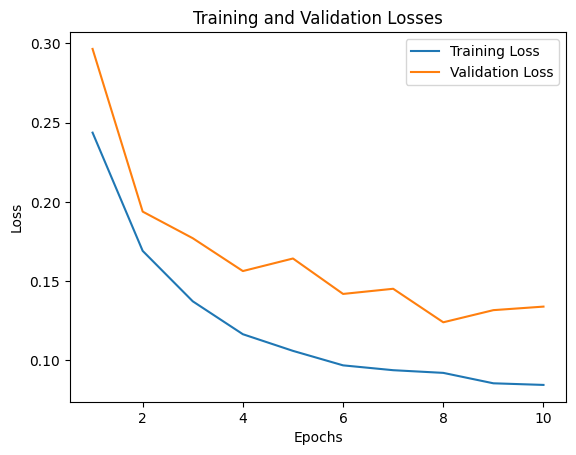

In [16]:
import matplotlib.pyplot as plt


# Plot losses versus epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

# Add legend
plt.legend()

# Show plot
plt.show()


In [17]:
# Save the model
torch.save(model.state_dict(), "Task_1_M1.pth")

In [27]:
# Evaluation
val_predictions=[]
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(val_dataset)):
        inputs=val_embeddings_tensor[i].unsqueeze(0)
        labels=val_labels_tensor[i].unsqueeze(0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(type(predicted))
        #print(predicted.item())
        #break
        val_predictions.append(predicted.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on val data: {accuracy:.2f}')

Accuracy on val data: 0.96


In [28]:
pred_emots=val_predictions

Flip recognition code

In [29]:
json_file_path = "val_file.json"

with open(json_file_path, "r") as f:
    val_data = json.load(f)

keys = list(val_data[0].keys())
for i in range(len(val_data[0])):
    print(keys[i],":", val_data[0][keys[i]])
    print(len(val_data[0][keys[i]]))
    print("\n")

episode : utterance_3421
14


speakers : ['Chandler', 'Joey', 'Chandler', 'Joey', 'Joey', 'Chandler', 'Joey', 'Joey', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey', 'Chandler', 'Joey']
17


emotions : ['anger', 'neutral', 'neutral', 'surprise', 'anger', 'disgust', 'neutral', 'neutral', 'neutral', 'anger', 'fear', 'surprise', 'neutral', 'sadness', 'sadness', 'surprise', 'neutral']
17


utterances : ['Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?', "I'd really prefer a mountain bike.", "Janice's birthday is coming up, I want to get her something speacial. Come in here with me.", 'Whoa, whoa, whoa, wait, whoa.', 'Do you ah, want to get her something speacial, get her flowers, get her candy, get her gum, girls love gum.', "That's a good idea, \x91Dear Janice have a Hubba-Bubba birthday'. I would like to get her something serious.", 'Oh, you want something serious.', "Y'know what you should do, you should get her one of those um, barium en

In [30]:
with open("chr_dict.json", "r") as f:
    chr_dict = json.load(f)

with open("emt_dict.json", "r") as f:
    emt_dict = json.load(f)

Create custom dataset for val data

In [31]:
comp_data_list_val = []
cnt = 0
tot_cnt = 0
for inst in range(len(val_data)):
    # Define the speaker dict
    speaker_dict = {}
    chr_list = val_data[inst]["speakers"]
    tot_cnt += len(chr_list)

    # Create empty speaker dict
    for j in chr_list:
        speaker_dict[chr_dict[j]] = {}

    # Number of utterances and fill in speaker dict
    for utt in range(len(val_data[inst]["utterances"])):
        speaker_dict[chr_dict[chr_list[utt]]][utt] = emt_dict[val_data[inst]["emotions"][utt]]

    # Assign index 1 as trigger list
    data_list = [speaker_dict,val_data[inst]["triggers"]]

    # Add it to the complete list
    comp_data_list_val.append(data_list)

    cnt += 1

print(tot_cnt)

7293


In [32]:
with open("comp_data_list_val.json", "w") as json_file:
    json.dump(comp_data_list_val, json_file)

Prediction Flip Loop


1. Run a loop for every set of utterences i.e. 843 in this case
2. Find the start and end indices i.e. how many dialouges for that one set of utterances
3. Then extract that subset of the pred emotes to a separate list
4. Find relative values and assign each emote to a char based on comp list indices
5. Find flips and report

In [33]:
# utts are the indexes of emotes that belong to this particular character
# emotes are the subsection of pred_emotes relevant to this scene
def return_flips (utt,emotes):
    flips = []
    for i in range(1,len(utt)):
        if emotes[utt[i-1]] != emotes[utt[i]]:
            flips.append(("u"+str(utt[i-1]),"u"+str(utt[i])))
    return flips

In [34]:
all_flips = []
cur_pointer = 0
for i in range(len(comp_data_list_val)):
    diag_len = len(comp_data_list_val[i][1]) # How many emotions to pick up == num of targets given at the end
    emots = pred_emots[cur_pointer:cur_pointer + diag_len]

    # For every character involved in the scene
    char_diag_dict = {} # maps character to its flips
    for char in comp_data_list_val[i][0]:
        utt = [int(j) for j in comp_data_list_val[i][0][char]]
        char_diag_dict[char] = return_flips(utt,emots)

    all_flips.append(char_diag_dict)

    cur_pointer += diag_len

In [35]:
with open("all_flips_val.json", "w") as json_file:
    json.dump(all_flips, json_file)

In [36]:
all_flips

[{86: [('u0', 'u2'),
   ('u2', 'u5'),
   ('u5', 'u9'),
   ('u9', 'u11'),
   ('u11', 'u13'),
   ('u13', 'u15')],
  148: [('u1', 'u3'),
   ('u3', 'u4'),
   ('u4', 'u6'),
   ('u8', 'u10'),
   ('u10', 'u12'),
   ('u12', 'u14'),
   ('u14', 'u16')]},
 {29: [],
  128: [('u1', 'u3'),
   ('u3', 'u5'),
   ('u5', 'u7'),
   ('u7', 'u9'),
   ('u10', 'u11'),
   ('u11', 'u13')],
  106: [('u2', 'u4'), ('u6', 'u8')]},
 {128: [('u2', 'u4'), ('u4', 'u6')],
  86: [('u1', 'u3'), ('u5', 'u7'), ('u7', 'u8')]},
 {36: [('u0', 'u2'), ('u2', 'u4')], 148: [('u3', 'u5')]},
 {153: [],
  31: [],
  148: [('u3', 'u4'), ('u4', 'u5')],
  36: [('u6', 'u8'), ('u10', 'u11')]},
 {153: [('u2', 'u5'), ('u7', 'u9'), ('u9', 'u11')],
  31: [('u1', 'u3')],
  86: [('u6', 'u8'), ('u8', 'u10'), ('u10', 'u12')]},
 {36: [('u0', 'u2'), ('u2', 'u4')], 18: [('u3', 'u5')]},
 {128: [],
  153: [('u1', 'u3')],
  86: [],
  31: [('u4', 'u6'), ('u6', 'u8')],
  11: [('u5', 'u7')]},
 {31: [('u0', 'u2'), ('u2', 'u4'), ('u4', 'u10')],
  148: [('u1'